### 연결된 ram 확인

In [ ]:
!nvidia-smi

Wed Jul 19 04:16:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Detectron2 및 종속된 파일 설치

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vyt3cph0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vyt3cph0
  Resolved https://github.com/facebookresearch/detectron2.git to commit 47d8ed7a1bd999719825f2e8a11d5b2828bc02c4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=7803871 sha256=0a7990170e556dbe68089e71bb434cec

### 라이브러리 버전 확인 및 import

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

### Roboflow에서 COCO segmentation Dataset 다운로드

- https://roboflow.com/

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gR8oJB7yYa4dW6hW93uk")
project = rf.workspace("cawilai-interns-july-2023").project("corrosion-instance-segmentation-sfcpc")
dataset = project.version(16).download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...
Exporting format coco-segmentation in progress : 85.0%
Version export complete for coco-segmentation format


Extracting Dataset Version Zip to Corrosion-Instance-Segmentation-16 in coco-segmentation:: 100%|██████████| 4950/4950 [00:02<00:00, 1744.25it/s]


### _annotations.coco.json(segmentation어노테이션 데이터 파일) train, valid, test 데이터셋 등록

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [ ]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
print(DATA_SET_NAME)
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

Corrosion-Instance-Segmentation


In [ ]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

### MetadataCatalog함수로 등록 여부 확인(https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [ ]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Corrosion-Instance-Segmentation-train',
 'Corrosion-Instance-Segmentation-test',
 'Corrosion-Instance-Segmentation-valid']

### train 학습 데이터 segmentation 시각화

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



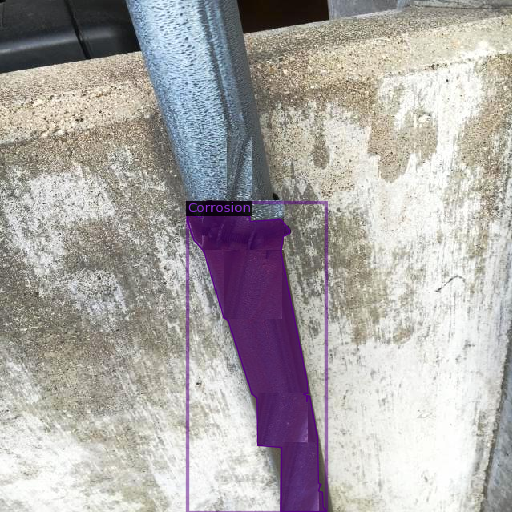

In [ ]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

## COCO dataset의 학습 모델 파라미터 설정

In [ ]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 2

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

### 모델 학습

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/19 04:49:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 172MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/19 04:49:38 d2.engine.train_loop]: Starting training from iteration 0
[07/19 04:49:50 d2.utils.events]:  eta: 0:16:25  iter: 19  total_loss: 4.331  loss_cls: 1.147  loss_box_reg: 0.6486  loss_mask: 0.6934  loss_rpn_cls: 1.618  loss_rpn_loc: 0.2631    time: 0.4953  last_time: 0.5822  data_time: 0.0299  last_data_time: 0.0350   lr: 1.9981e-05  max_mem: 2757M
[07/19 04:50:05 d2.utils.events]:  eta: 0:16:23  iter: 39  total_loss: 3.818  loss_cls: 0.9407  loss_box_reg: 0.6231  loss_mask: 0.6824  loss_rpn_cls: 1.216  loss_rpn_loc: 0.4934    time: 0.5237  last_time: 0.5991  data_time: 0.0442  last_data_time: 0.0400   lr: 3.9961e-05  max_mem: 3649M
[07/19 04:50:15 d2.utils.events]:  eta: 0:16:07  iter: 59  total_loss: 2.633  loss_cls: 0.7595  loss_box_reg: 0.5057  loss_mask: 0.6608  loss_rpn_cls: 0.5096  loss_rpn_loc: 0.342    time: 0.5153  last_time: 0.4271  data_time: 0.0293  last_data_time: 0.0076   lr: 5.9941e-05  max_mem: 3649M
[07/19 04:50:25 d2.utils.events]:  eta: 0:15:53  iter: 79

### train graph

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

### 모델 평가

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[07/19 05:08:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Corrosion-Instance-Segmentation/mask_rcnn_R_101_FPN_3x/2023-07-19-04-49-27/model_final.pth ...


### test 시각화

In [ ]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])